# Fragile Families Challenge
## Onur Varol
@onurvarol | www.onurvarol.com

In [2]:
%pylab inline
import os, sys, glob, copy
import gzip

import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 

from data_access import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
print OUTCOMES

fDefinition = get_feature_name_definitions()
with open('data/processed_data/feature_list.txt','w') as fl:
    for f in get_feature_list():
        fl.write('{}: {}\n'.format(f, fDefinition.get(f,'')))


['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']


In [3]:
trX, trY, teX, uidLbls = create_data_matrix(featureList=get_core_feature_list(), outcome='gpa')

TrX: (1165, 9840), TrY: (1165,), TeX: (3077, 9840)


In [10]:
def evaluate_model(model, trX, trY, teX, uids, features=None):
    kf = KFold(n_splits=10)
    mse = list()
    foldC = 0
    
    expResults = {'folds':list(), 'model':str(model),
                  'userIds':uids, 'features': features
                 }
    for train_index, test_index in kf.split(trX):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = trX[train_index], trX[test_index]
        y_train, y_test = trY[train_index], trY[test_index]
        
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)
        
        mse.append(np.mean((ypred - y_test) ** 2))
        foldC += 1
        print foldC, mse[-1]
        
        # Keep track of feature importance scores
        predTest = regressor.predict(teX)
        expResults['folds'].append({'predictions': predTest,
                                    'feature_importance': list(model.feature_importances_),
                                    'mse': mse[-1],
                                   })
    print np.mean(mse), mse
    
    # Model using whole training data
    model.fit(trX, trY)
    ypred = model.predict(teX)
    expResults['all'] = {'predictions': ypred,
                         'feature_importance': list(model.feature_importances_),
                        }
    return expResults


In [14]:
### FEATURE SELECTION FROM CORE FEATURES
# Run model for each outcome seperately
selectedFeatures = get_core_feature_list()
selectedFeatures = select_feature_by_type(features=selectedFeatures, prefix=['k'])
print len(selectedFeatures)

#'''
for oc in OUTCOMES:
    print '### {} ###'.format(oc)
    trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, outcome=oc)
    regressor = RandomForestRegressor(n_estimators=100)
    expRes = evaluate_model(regressor, trX, trY, teX, uidLbls, selectedFeatures)
    pickle.dump(expRes, open('experiments/results_prefixkfeatures_RFregression_10CV_{}.pkl'.format(oc),'wb'))
#'''
    
for oc in ["eviction","layoff","jobTraining"]:
    print '### {} ###'.format(oc)
    trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, outcome=oc)
    model = RandomForestClassifier(n_estimators=100)
    expRes = evaluate_model(model, trX, trY, teX, uidLbls, selectedFeatures)
    pickle.dump(expRes, open('experiments/results_prefixkfeatures_RFclassification_10CV_{}.pkl'.format(oc),'wb'))


108
### gpa ###
TrX: (1165, 108), TrY: (1165,), TeX: (3077, 108)
1 0.320324254431
2 0.418841161319


KeyboardInterrupt: 

In [6]:
### FEATURE SELECTION USING CORE AND MISSING FEATURE COUNTS
'''
# Run this part once to compute features
missingUserFeatures = dict()
missingFeatures = set()
for uid, mfeat in iterate_user_missing_features():
    missingUserFeatures[uid] = mfeat
    missingFeatures |= set(mfeat.keys())
missingFeatures = list(missingFeatures)
print len(missingFeatures), 'missing features'
pickle.dump(missingUserFeatures, open('data/processed_data/features_missing_survey_counts.pkl','wb'))
'''

# Load precomputed features
missingUserFeatures = pickle.load(open('data/processed_data/features_missing_survey_counts.pkl','rb'))
missingFeatures = set()
for u in missingUserFeatures:
    missingFeatures |= set(missingUserFeatures[u].keys())
missingFeatures = list(missingFeatures)
print len(missingFeatures), 'missing features'

#selectedFeatures = get_core_feature_list()
#selectedFeatures = selectedFeatures + missingFeatures
selectedFeatures = missingFeatures
print len(selectedFeatures)

for oc in OUTCOMES:
    print '### {} ###'.format(oc)
    uIterator = combine_user_feature_iterators([missingUserFeatures])
    trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, 
                                                outcome=oc, userFeatureIterator=uIterator)
    regressor = RandomForestRegressor(n_estimators=100)
    expRes = evaluate_model(regressor, trX, trY, teX, uidLbls, selectedFeatures)
    #pickle.dump(expRes, open('experiments/results_wMissingCountfeatures_RFregression_10CV_{}.pkl'.format(oc),'wb'))
    pickle.dump(expRes, open('experiments/results_missingfeatures_RFregression_10CV_{}.pkl'.format(oc),'wb'))
    
    
for oc in ["eviction","layoff","jobTraining"]:
    print '### {} ###'.format(oc)
    uIterator = combine_user_feature_iterators([missingUserFeatures])
    trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, 
                                                outcome=oc, userFeatureIterator=uIterator)
    model = RandomForestClassifier(n_estimators=100)
    expRes = evaluate_model(model, trX, trY, teX, uidLbls, selectedFeatures)
    #pickle.dump(expRes, open('experiments/results_wMissingCountfeatures_RFclassification_10CV_{}.pkl'.format(oc),'wb'))
    pickle.dump(expRes, open('experiments/results_missingfeatures_RFclassification_10CV_{}.pkl'.format(oc),'wb'))


98 missing features
98
### gpa ###
TrX: (1165, 98), TrY: (1165,), TeX: (3077, 98)
1 0.359525412473
2 0.450526398606
3 0.441019177641
4 0.513540109246
5 0.460386622863
6 0.572469953584
7 0.550042582525
8 0.619331310824
9 0.539105512872
10 0.452298497382
0.495824557802 [0.35952541247294967, 0.45052639860558219, 0.44101917764054893, 0.51354010924586568, 0.46038662286295345, 0.57246995358379849, 0.55004258252536908, 0.61933131082444648, 0.53910551287179853, 0.45229849738205308]
### grit ###
TrX: (1418, 98), TrY: (1418,), TeX: (2824, 98)
1 0.302907316677
2 0.287310950409
3 0.249735290042
4 0.263255426305
5 0.245695469876
6 0.295133774259
7 0.27321829732
8 0.249748034736
9 0.233327560679
10 0.269626301496
0.26699584218 [0.3029073166772453, 0.28731095040928606, 0.24973529004184869, 0.26325542630453364, 0.24569546987603313, 0.29513377425920867, 0.27321829732018271, 0.24974803473621351, 0.23332756067889079, 0.26962630149568417]
### materialHardship ###
TrX: (1459, 98), TrY: (1459,), TeX: (2783,

In [6]:
keyword =  'employment' #'place'
selectedFeatures = get_feature_by_keyword(keyword)
print len(selectedFeatures)

for oc in OUTCOMES:
    print '### {} ###'.format(oc)
    trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, outcome=oc)
    
    if oc in ["eviction","layoff","jobTraining"]:
        model = RandomForestClassifier(n_estimators=100)
        expRes = evaluate_model(model, trX, trY, teX, uidLbls, selectedFeatures)
        pickle.dump(expRes, open('experiments/results_{}-features_RFclassification_10CV_{}.pkl'.format(keyword,oc),'wb'))
    else:
        regressor = RandomForestRegressor(n_estimators=100)
        expRes = evaluate_model(regressor, trX, trY, teX, uidLbls, selectedFeatures)
        pickle.dump(expRes, open('experiments/results_{}-features_RFregression_10CV_{}.pkl'.format(keyword,oc),'wb'))

34
### gpa ###
TrX: (1165, 34), TrY: (1165,), TeX: (3077, 34)
1 0.394162868983
2 0.502007941108
3 0.450153307262
4 0.511515591946
5 0.51667929529
6 0.444879411577
7 0.529976861482
8 0.564772235625
9 0.523822369104
10 0.408782282365
0.484675216474 [0.39416286898308533, 0.50200794110803915, 0.45015330726219149, 0.51151559194620266, 0.51667929528980494, 0.44487941157662686, 0.52997686148187639, 0.56477223562503454, 0.52382236910446744, 0.40878228236464015]
### grit ###
TrX: (1418, 34), TrY: (1418,), TeX: (2824, 34)
1 0.298462817622
2 0.283562941445
3 0.318951800383
4 0.321337296635
5 0.238444922458
6 0.342313112584
7 0.281938994619
8 0.299144688438
9 0.27464356782
10 0.264256429568
0.292305657157 [0.2984628176220111, 0.28356294144461275, 0.31895180038290016, 0.32133729663457994, 0.23844492245829879, 0.34231311258414138, 0.28193899461948468, 0.29914468843842518, 0.2746435678196581, 0.26425642956753564]
### materialHardship ###
TrX: (1459, 34), TrY: (1459,), TeX: (2783, 34)
1 0.029723448903

In [9]:
# Eviction classification
# https://github.com/gwgundersen/fragile-families/blob/master/paper/eviction.pdf
selectedFeatures = ['m4a3','hv3pvnceil','ffcc_centsurvey_b2','m3a3c','hv4l50',
                    'm3a3b1','m3f2f2','m2k17e1','m2j15b','m3a3e'
                    ,'m2j15f','m2j15c','m3f2d10','m3b32g','m2j15a']
oc = 'eviction'

trX, trY, teX, uidLbls = create_data_matrix(featureList=selectedFeatures, outcome=oc)
    
model = RandomForestClassifier(n_estimators=100)
expRes = evaluate_model(model, trX, trY, teX, uidLbls, selectedFeatures)
pickle.dump(expRes, open('experiments/results_evictionListfeatures_RFclassification_10CV_{}.pkl'.format(keyword,oc),'wb'))


TrX: (1459, 15), TrY: (1459,), TeX: (2783, 15)
1 0.0684931506849
2 0.0684931506849
3 0.109589041096
4 0.102739726027
5 0.041095890411
6 0.0479452054795
7 0.0479452054795
8 0.0684931506849
9 0.0616438356164
10 0.0206896551724
0.0637128011337 [0.068493150684931503, 0.068493150684931503, 0.1095890410958904, 0.10273972602739725, 0.041095890410958902, 0.047945205479452052, 0.047945205479452052, 0.068493150684931503, 0.061643835616438353, 0.020689655172413793]


In [12]:
'''
# TEMP fix: First experiments doesn't have list of features. Append them
selectedFeatures = get_core_feature_list()
selectedFeatures = select_feature_by_type(features=selectedFeatures, wave=[5])
for fname in glob.glob('experiments/results_wave5features_*.pkl'):
    print fname
    expRes = pickle.load(open(fname,'rb'))
    expRes['features'] = selectedFeatures
    pickle.dump(expRes, open(fname,'wb'))
'''

experiments/results_wave5features_RFclassification_10CV_eviction.pkl
experiments/results_wave5features_RFclassification_10CV_jobTraining.pkl
experiments/results_wave5features_RFclassification_10CV_layoff.pkl
experiments/results_wave5features_RFregression_10CV_eviction.pkl
experiments/results_wave5features_RFregression_10CV_gpa.pkl
experiments/results_wave5features_RFregression_10CV_grit.pkl
experiments/results_wave5features_RFregression_10CV_jobTraining.pkl
experiments/results_wave5features_RFregression_10CV_layoff.pkl
experiments/results_wave5features_RFregression_10CV_materialHardship.pkl


(3077,)
(2824,)
(2783,)
(2783,)
(2965,)
(2781,)


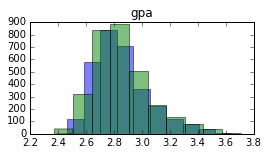

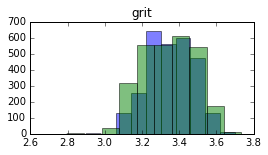

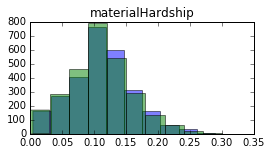

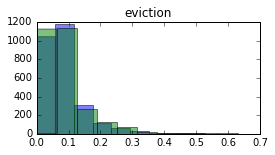

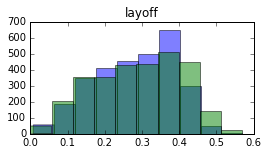

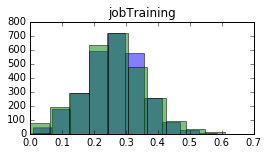

In [30]:
# Plot histogram of test scores
for oc in OUTCOMES:
    expRes = pickle.load(open('experiments/results_corefeatures_RFregression_10CV_{}.pkl'.format(oc),'rb'))
    
    testScores = list()
    for fold in expRes['folds']:
        testScores.append(list(fold['predictions']))
    testScores = np.array(testScores)
    testScores = np.mean(testScores, axis=0)
    print testScores.shape
    
    oneScore = expRes['all']['predictions']
    
    plt.figure(figsize=(4,2))
    plt.hist(testScores, alpha=0.5)
    plt.hist(oneScore, alpha=0.5)
    plt.title(oc)
    #break

In [16]:
# List top features
featureNameDefinitions = get_feature_name_definitions()
modelName = 'experiments/results_wave5features_RFregression_10CV_gpa.pkl'
expRes = pickle.load(open(modelName,'rb'))

fImportance = dict()
for i,v in enumerate(expRes['all']['feature_importance']):
    fImportance[expRes['features'][i]] = v

for f in sorted(fImportance, key=fImportance.get, reverse=True)[:10]:
    print f, fImportance[f], featureNameDefinitions.get(f,'')

 cm5hhinc 0.0367885298053 Constructed - Mother's Household income (with imputed values)
hv5_wj10ss 0.0319833470013 Woodcock Johnson Test 10 standard score
hv5_ppvtss 0.0187094520198 PPVT standard score
hv5_ppvtraw 0.0151903709348 PPVT raw score
t5c13c 0.0103794637889 c13C. Child's mathematical skills
cf5povcob 0.00890462541909 Constructed - father's household income/poverty threshold at 9-year, mother repo
k5f1 0.00777183018851 
cf5hhincb 0.00703591506302 Constructed - Household income mother report for married/cohab if available (wit
f5j6c 0.00653223666456 J6C. Value of vehicle if sold
hv5_wj9ss 0.00593564118785 Woodcock Johnson Test 9 standard score


In [13]:
def prepare_prediction_file(predictions, path='data/submissions/'):
    with open(path + 'prediction.csv', 'w') as fl:
        fl.write('"challengeID","gpa","grit","materialHardship","eviction","layoff","jobTraining"\n')
        for u in predictions:
            fl.write('{},{}\n'.format(u, ','.join([str(predictions[u][o]) for o in OUTCOMES])))


oPredictions = dict()
for uid, lbls in iterate_training_data():
    oPredictions[int(uid)] = lbls

modelStr = 'prefixkfeatures'
for oc in OUTCOMES:
    # Produce also binary outcomes for ["eviction","layoff","jobTraining"]
    if oc in ["eviction","layoff","jobTraining"]:
        expRes = pickle.load(open('experiments/results_{}_RFclassification_10CV_{}.pkl'.format(modelStr,oc),'rb'))
    else:
        expRes = pickle.load(open('experiments/results_{}_RFregression_10CV_{}.pkl'.format(modelStr,oc),'rb'))
    
    #print expRes['model']
    uidLbls = expRes['userIds']
    teIdx = sorted([int(u) for u in uidLbls if uidLbls[u] == False])
    
    #for i,s in enumerate(expRes['all']['predictions']):
    #    if teIdx[i] not in oPredictions:
    #        oPredictions[teIdx[i]] = dict()
    #    oPredictions[teIdx[i]][oc] = s
    
    # Add average of scores
    #'''
    
    for i in range(len(teIdx)):
        if teIdx[i] not in oPredictions:
            oPredictions[teIdx[i]] = dict()
        
        #if oc in ["eviction","layoff","jobTraining"]:
        #    mscore = np.mean([f['predictions'][i] for f in expRes['folds']])
        #    oPredictions[teIdx[i]][oc] = 1 if mscore > 0.5 else 0
        #else:
        #    oPredictions[teIdx[i]][oc] = np.mean([f['predictions'][i] for f in expRes['folds']])
        oPredictions[teIdx[i]][oc] = np.mean([f['predictions'][i] for f in expRes['folds']])
    #'''

for u in sorted(oPredictions)[:20]:
    print u, [oPredictions[u][o] for o in OUTCOMES]

prepare_prediction_file(oPredictions, 'data/submissions/12/')

1 [3.0428842762252524, 3.4252556089041279, 0.091461628321531471, 0.26847814348097188, 0.26847814348097188, 0.26847814348097188]
2 [2.8745000000000003, 3.5722500000000004, 0.084818181818181904, 0.11000000000000001, 0.11000000000000001, 0.11000000000000001]
3 [3.0428842762252524, 3.4252556089041279, 0.091461628321531471, 0.26847814348097188, 0.26847814348097188, 0.26847814348097188]
4 [3.1027500000000003, 3.4225000000000003, 0.10736363636363641, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001]
5 [2.6849999999999996, 3.2992499999999998, 0.13181818181818197, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002]
6 [2.7759999999999998, 3.5, 0.0909090909090909, 0.0, 0.0, 0.0]
7 [2.5, 3.25, 0.0, 0.0, 0.0, 0.0]
8 [3.0428842762252524, 3.4252556089041279, 0.091461628321531471, 0.26847814348097188, 0.26847814348097188, 0.26847814348097188]
9 [2.25, 4.0, 0.181818181818182, 0.0, 0.0, 0.0]
10 [3.25, 3.25, 0.0909090909090909, 0.0, 0.21000000000000002, 0.0]
11 [2.742, 3.470250000